In [14]:
from google.cloud.aiplatform import hyperparameter_tuning as hpt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from skopt import BayesSearchCV

import google.cloud.aiplatform as aiplatform
import numpy as np
import pandas as pd

## Loading the data

In [4]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

## Data Attributes

Information about the columns of data:
| **Index** | **Feature** | **Description** |
|-----------|-------------|-----------------|
| 1         | CRIM        | per capita crime rate by town |
| 2         | ZN          | proportion of residential land zoned for lots over 25,000 sq.ft. |
| 3         | INDUS       | proportion of non-retail business acres per town |
| 4         | CHAS        | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| 5         | NOX         | nitric oxides concentration (parts per 10 million) |
| 6         | RM          | average number of rooms per dwelling |
| 7         | AGE         | proportion of owner-occupied units built prior to 1940 |
| 8         | DIS         | weighted distances to five Boston employment centres |
| 9         | RAD         | index of accessibility to radial highways |
| 10        | TAX         | full-value property-tax rate per $10,000 |
| 11        | PTRATIO     | pupil-teacher ratio by town |
| 12        | B           | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| 13        | LSTAT       | % lower status of the population |
| 14        | MEDV        | Median value of owner-occupied homes in $1000's |

In [7]:
data = pd.DataFrame(data, columns=["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"])
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [11]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [10]:
data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [32]:
data['Target'] = target
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [33]:
data.to_csv("trainer/boston.csv", index=False)

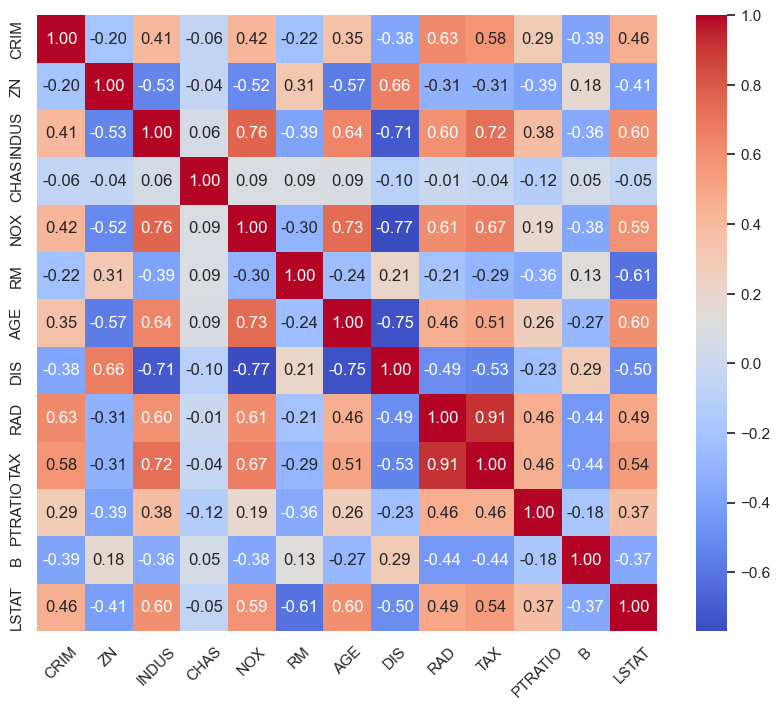

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.xticks(rotation=45)
plt.show()

## Train Test Split and Data Regularization

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=7)

In [16]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
hyperparameters = {
    "n_estimators": np.linspace(10, 100, 10, dtype=int),
    "max_depth": np.linspace(1, 10, 10, dtype=int),
    "min_samples_split": np.linspace(2, 10, 9, dtype=int),
    "min_samples_leaf": np.linspace(1, 10, 10, dtype=int),
}

In [28]:
model = RandomForestRegressor()

opt = BayesSearchCV(
    model,
    hyperparameters,
    n_iter       = 16,
    cv           = 3,
    n_jobs       = -1,
    random_state = 7,
    scoring      = "neg_mean_squared_error",
    verbose      = 2
)

opt.fit(X_train_scaled, y_train)

print("Best hyperparameters:", opt.best_params_)
print("Best score:", -1*opt.best_score_)
print("Test score:", -1*opt.score(X_test_scaled, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best hyperparameters: OrderedDict([('max_depth', 10), ('

In [35]:
parameter_spec = {
    "n_estimators": hpt.IntegerParameterSpec(min=10, max=100, scale="linear"),
    "max_depth": hpt.IntegerParameterSpec(min=1, max=10, scale="linear"),
    "min_samples_split": hpt.IntegerParameterSpec(min=2, max=10, scale="linear"),
    "min_samples_leaf": hpt.IntegerParameterSpec(min=1, max=10, scale="linear"),
}

metric_spec = {"mean_squared_error": "minimize"}

In [ ]:
worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": "n1-standard-4",
            "accelerator_type": "NVIDIA_TESLA_T4",
            "accelerator_count": 1,
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": "australia.gcr.io/deep-chimera-268715/boston:latest"
        },
    }
]

my_custom_job = aiplatform.CustomJob(
    display_name="my-custom-job",
    worker_pool_specs=worker_pool_specs,
    staging_bucket="gs://{YOUR_BUCKET}",
)